In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
j_faults = pd.read_csv('../data/J1939Faults.csv').reset_index(drop = True)
onboard_data = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv').reset_index(drop = True)
fault_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx').reset_index(drop = True)
vehicle = pd.read_excel('../data/Vehicle_Make.xlsx').reset_index(drop = True)

C:\Users\hjrko\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ob_data = onboard_data.pivot(index='FaultId', columns='Name',values = 'Value').rename_axis(None)
pd.set_option('display.max_columns', None)
ob_data.reset_index(inplace=True)
ob_data = ob_data.rename(columns = {'index':'FaultId'})

In [4]:
ob_faults = pd.merge(j_faults, ob_data, how='left', left_on='RecordID', right_on='FaultId')

In [5]:
ob_faults['null_count'] = ob_faults.isnull().sum(axis=1)

In [6]:
problem_cols = ['AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure']

for x in problem_cols:
    try:
        ob_faults[x] = ob_faults[x].str.replace(',','').astype(float)
    except ValueError:
        ob_faults[x] = ob_faults[x]
ob_faults['EventTimeStamp'] =  pd.to_datetime(ob_faults['EventTimeStamp'], format='%Y%m%d %H:%M:%S.%f')
ob_faults['LocationTimeStamp'] =  pd.to_datetime(ob_faults['EventTimeStamp'], format='%Y%m%d %H:%M:%S.%f')

In [7]:
ob_faults['repair_center'] = False
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.43\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.06\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-86.44\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'35.58\d+')), 'repair_center'] = True
ob_faults.loc[(ob_faults['Longitude'].astype('str').str.contains(r'-83.17\d+')) & (ob_faults['Latitude'].astype('str').str.contains(r'36.19\d+')), 'repair_center'] = True
ob_faults = ob_faults[ob_faults['repair_center']==False]

In [8]:
ob_faults['EquipmentID'] = ob_faults['EquipmentID'].astype(str)
ob_faults = ob_faults[ob_faults['EquipmentID'].str.len()  < 6]

In [9]:
combined_df = ob_faults.drop(columns=['actionDescription','repair_center','faultValue'])

In [10]:
combined_df

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,null_count
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,17,True,2,1439,105354361,38.857638,-84.626851,2015-02-21 10:47:13,1,0.0,14.2100,False,66.48672,423178.70000,100.4,11.0,0.00,96.74375,0.00,1632.20,43.2,12300.907429,0.000000,NaN,False,78.8,1023.0,True,NaN,0.00000,3276.75,NaN,0.00,5
1,2,990360,2015-02-21 11:34:34,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:34,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,25
2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,1807,2,False,127,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:31,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,25
3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,1807,2,True,127,1369,105336226,41.421018,-87.767361,2015-02-21 11:35:33,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,NaN,24
4,5,990416,2015-02-21 11:39:41,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:41,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16639.0,NaN,NaN,NaN,NaN,NaN,NaN,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26,Low (Severity Low) Catalyst Tank Level,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:26,1248454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,25
1187331,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:23,1248455,100.0,14.5000,True,64.62260,423937.90000,185.0,51.0,37.12,211.49370,1310.25,10722.70,96.4,58979.184416,7.647805,32.0,True,98.6,18431.0,False,NaN,65.01096,NaN,73.2,7.83,4
1187332,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,1850,105336308,34.430370,-84.920509,2020-03-06 14:13:38,1248456,0.0,14.3550,True,66.48672,465925.40000,186.8,62.0,41.18,212.84380,1340.75,9326.75,100.0,65080.105870,8.995086,NaN,True,91.4,17407.0,NaN,NaN,66.57410,NaN,100.0,6.96,6
1187333,1248457,123906113,2020-03-06 14:14:13,Low (Severity Medium) Engine Coolant Level,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:13,1248457,1.6,14.4275,False,67.72946,28606.65625,181.4,0.0,27.26,221.73120,863.25,586.75,23.6,4042.492826,0.000000,NaN,True,100.4,1023.0,False,NaN,11.84489,14.10,100.0,1.74,7


In [11]:
condensed_df = combined_df.sort_values(['EquipmentID', 'EventTimeStamp', 'spn', 'fmi'])[[
    'EquipmentID', 
    'EventTimeStamp', 
    'eventDescription', 
    'spn', 
    'fmi', 
    'active', 
    'activeTransitionCount', 
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlActive',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IgnStatus',
    'IntakeManifoldTemperature',
    'LampStatus',
    'ParkingBrake',
    'ServiceDistance',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']]

mask = ((condensed_df['spn'].shift(-1) == 5246))

spn_prior_to_derate = condensed_df[mask]

spn_count = spn_prior_to_derate.groupby('spn').count().reset_index().sort_values('EquipmentID', ascending=False).head(20)

C:\Users\hjrko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


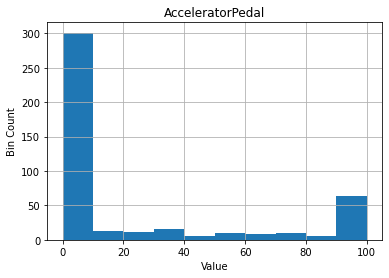

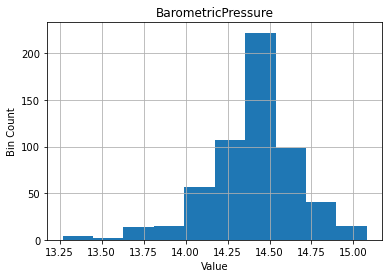

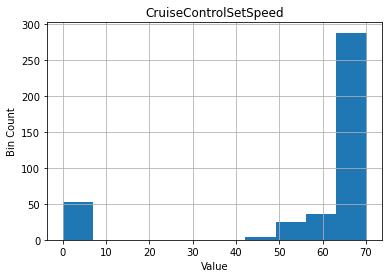

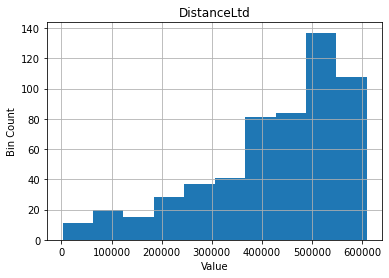

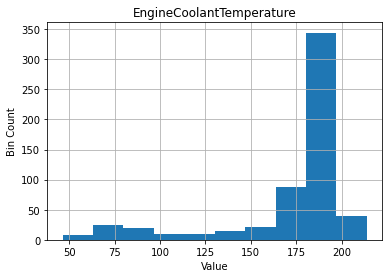

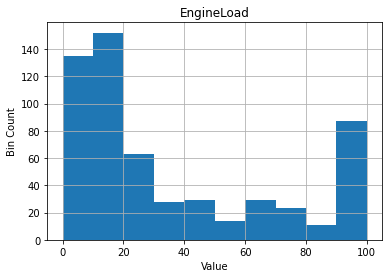

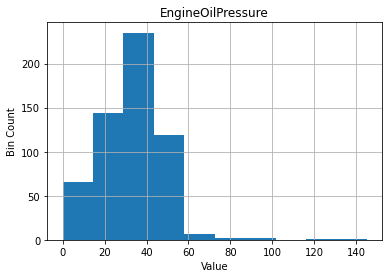

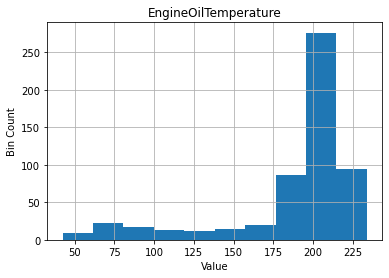

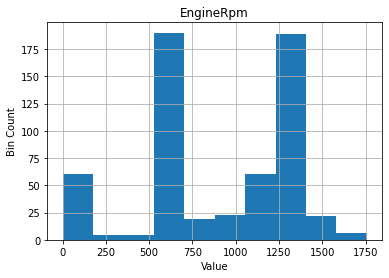

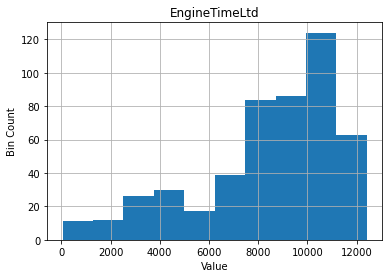

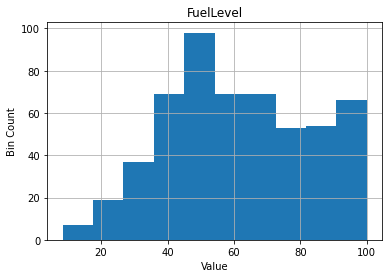

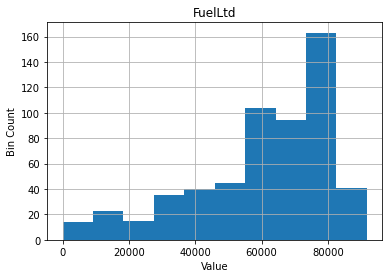

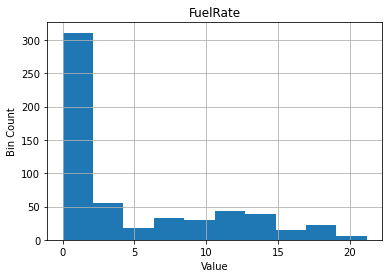

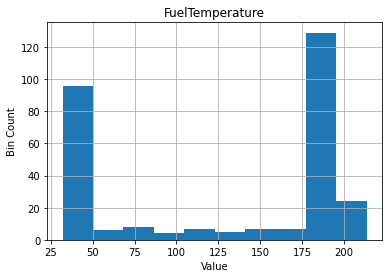

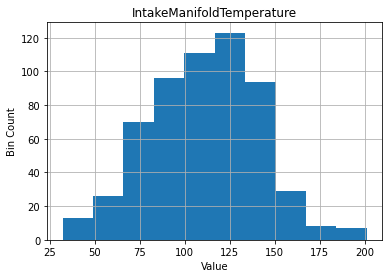

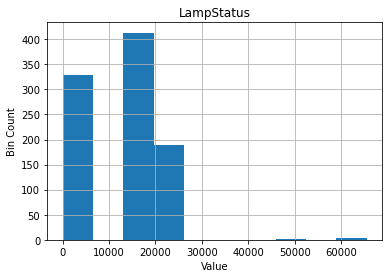

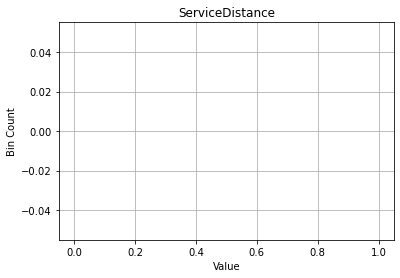

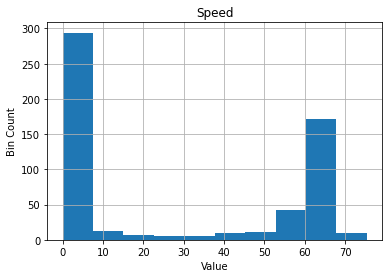

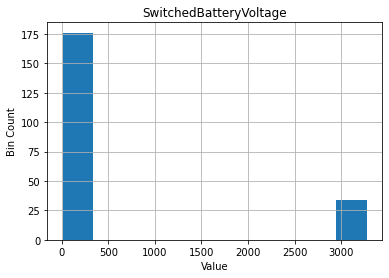

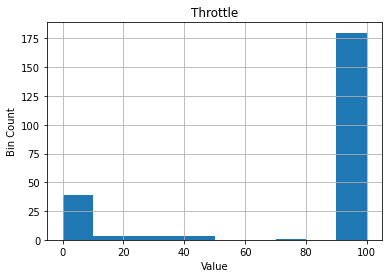

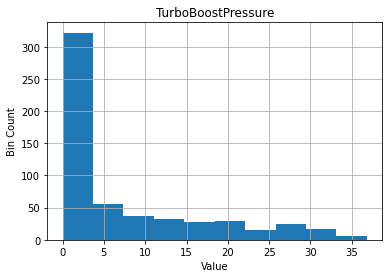

In [12]:
problem_cols_num = [
    'AcceleratorPedal',
    'BarometricPressure',
    'CruiseControlSetSpeed',
    'DistanceLtd',
    'EngineCoolantTemperature',
    'EngineLoad',
    'EngineOilPressure',
    'EngineOilTemperature',
    'EngineRpm',
    'EngineTimeLtd',
    'FuelLevel',
    'FuelLtd',
    'FuelRate',
    'FuelTemperature',
    'IntakeManifoldTemperature',
    'LampStatus',
    'ServiceDistance',
    'Speed',
    'SwitchedBatteryVoltage',
    'Throttle',
    'TurboBoostPressure']

for x in problem_cols_num:
    spn_prior_to_derate.hist(x)
    plt.xlabel('Value')
    plt.ylabel('Bin Count')
    plt.title(x)

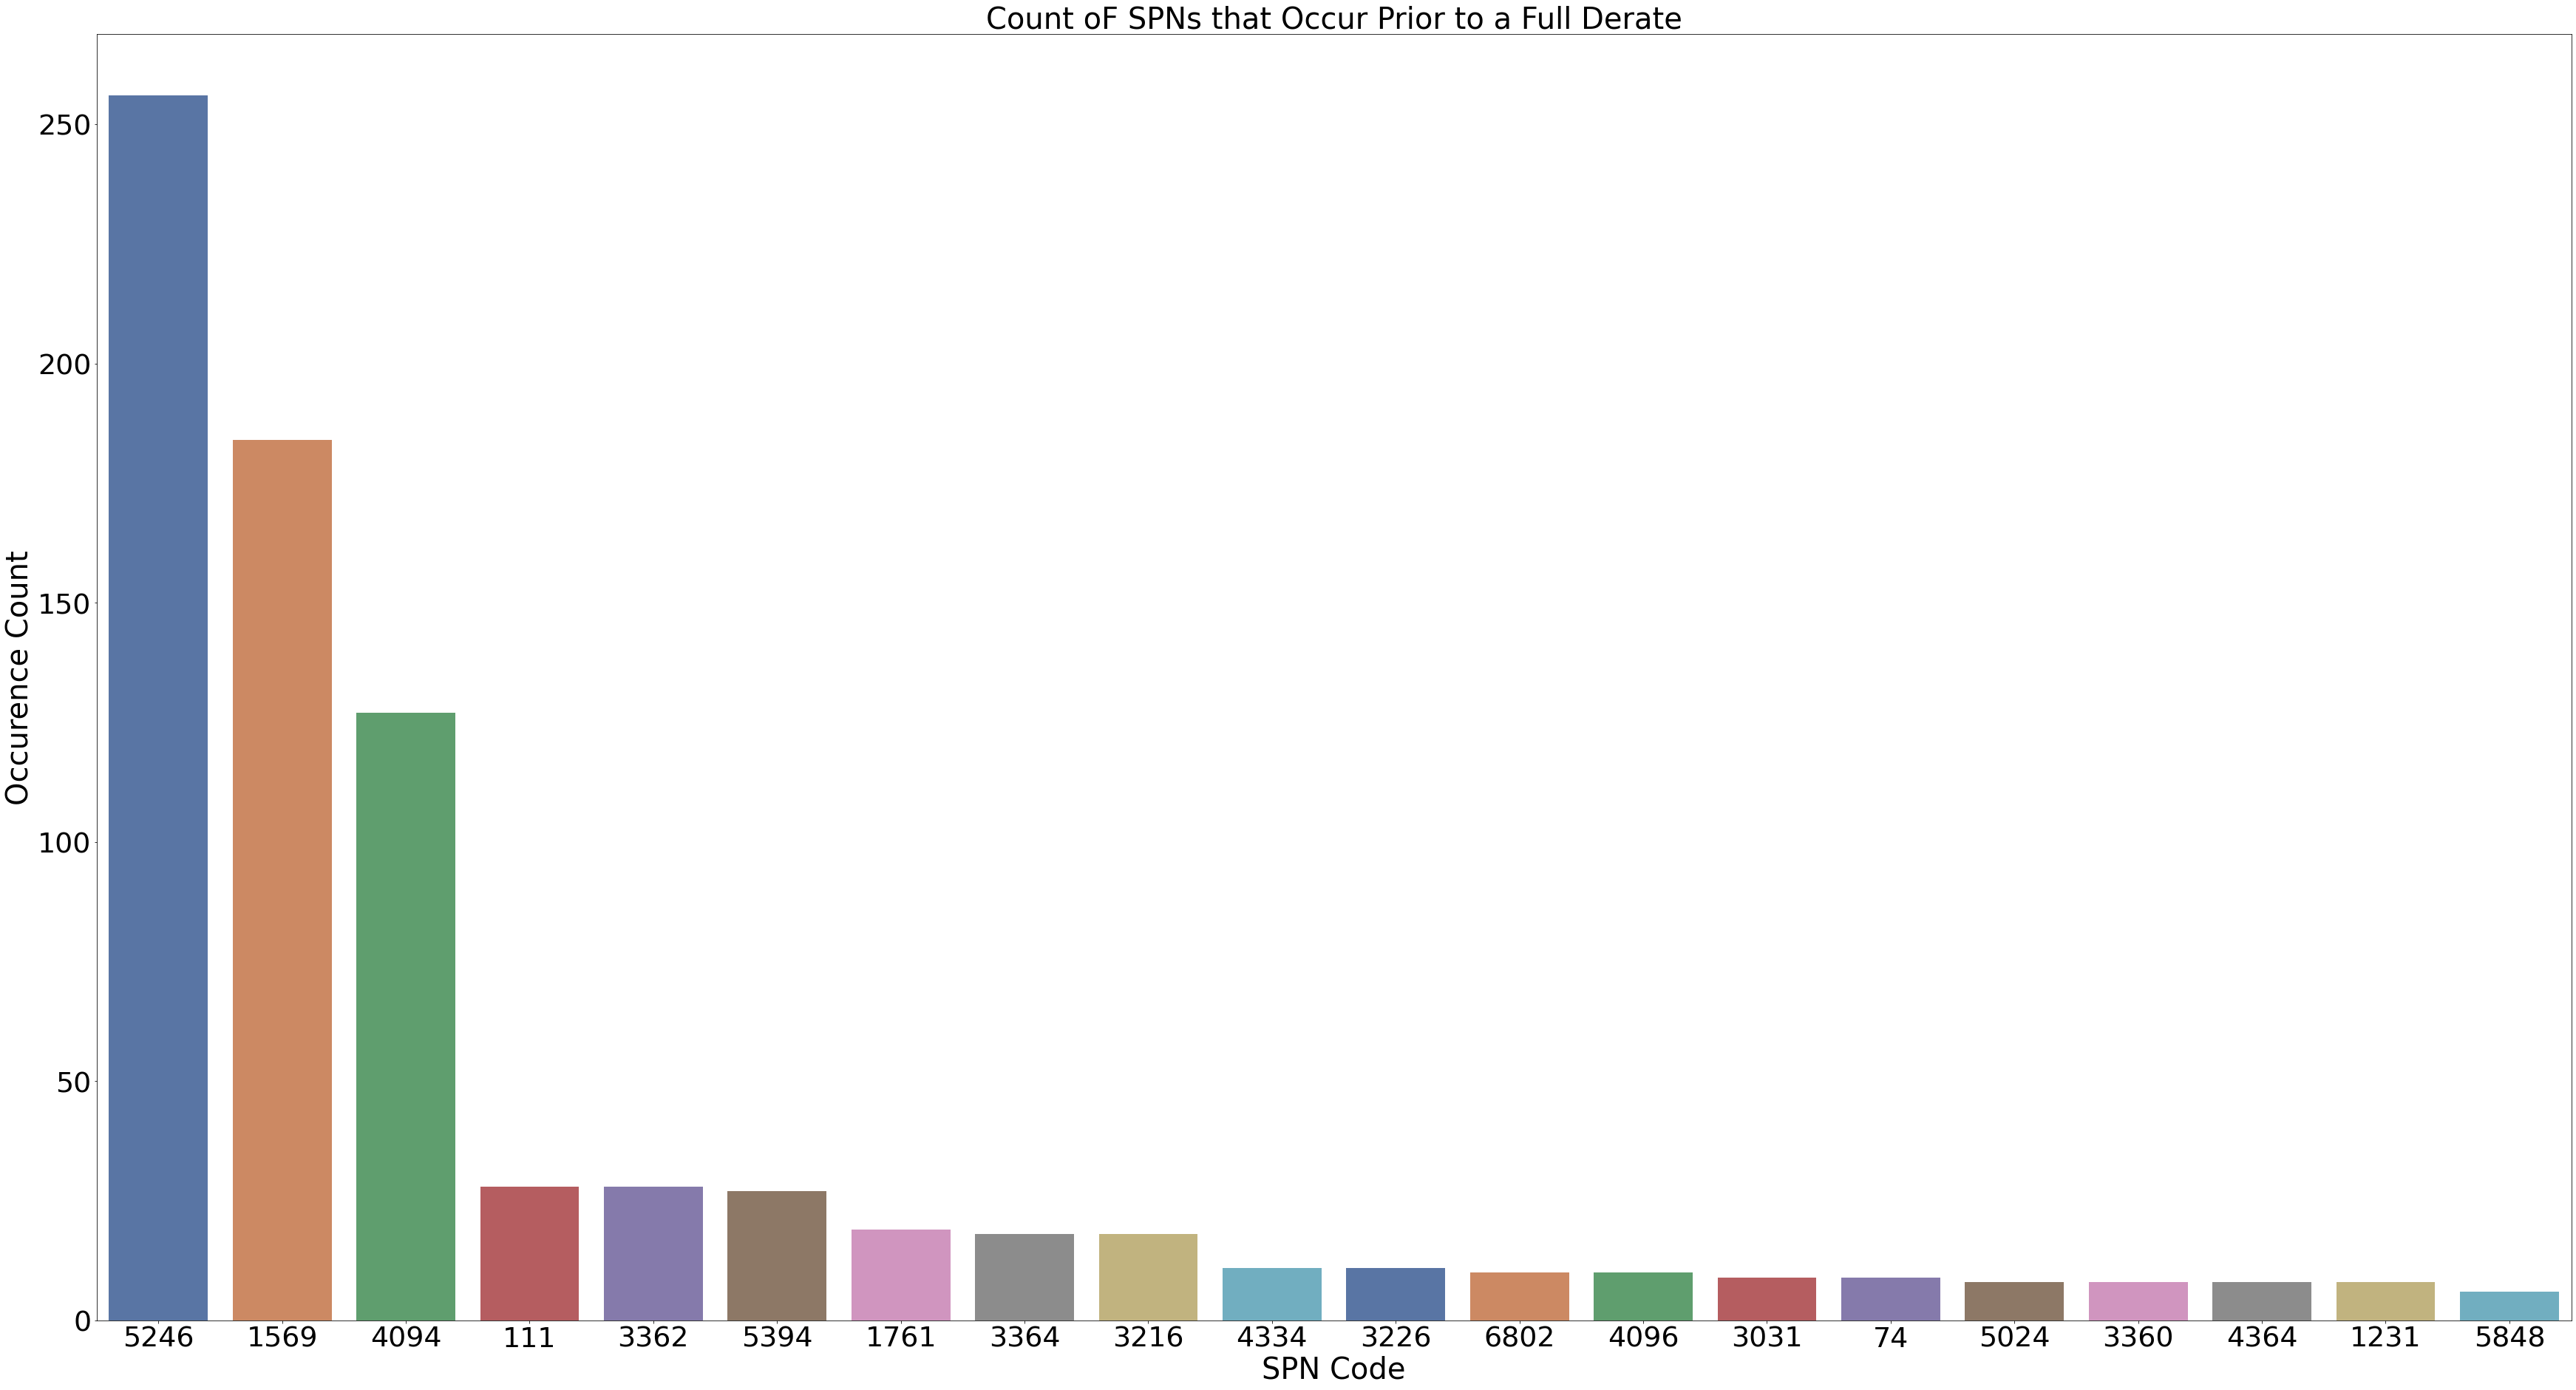

In [13]:
fontsize = 40

fig, ax = plt.subplots(figsize=(60, 32))
sns.barplot(x = 'spn', 
            y = 'EquipmentID', 
            data = spn_count, 
            dodge = False, 
            palette = "deep",
            ax = ax,
            order = spn_count.sort_values('EquipmentID', ascending=False).spn)

plt.xlabel('SPN Code', fontsize = fontsize)
plt.xticks(fontsize = fontsize - 2)

plt.ylabel('Occurence Count', fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)

plt.title('Count oF SPNs that Occur Prior to a Full Derate', fontsize = fontsize);